In [1]:
%load_ext autoreload

In [2]:
import os
import sys
import re
from argparse import Namespace

sys.path.append('../src-py/')

os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [43]:
%autoreload

from utils import *
from project_debater_api import *
from mt_bart_v2 import *

In [68]:
import torch
import json

import nltk
import numpy as np
import pandas as pd

from pathlib import Path
from datasets import load_dataset, load_metric, Dataset

from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import BartTokenizer, BartForConditionalGeneration

import matplotlib.pyplot as plt

In [5]:
from tabulate import tabulate

In [6]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [8]:
device

device(type='cuda')

In [9]:
ceph_dir = '/home/sile2804/data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation'
local_home_dir = '../data'

In [90]:
def generate_ds_multi_attacks(ds, model, tokenizer, premises_clm, conclusion_clm, gen_kwargs, skip_special_tokens=True, batch_size=16, nb_counters=5):
    multi_attacks = []
    for i in range(nb_counters):
        proc_ds = ds.map(lambda x :preprocess_function(x, tokenizer, premises_clm, 'counter', conclusion_clm=conclusion_clm, conclusion_idx=i), batched=True)
        proc_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
        dataloader = torch.utils.data.DataLoader(proc_ds, batch_size=batch_size)
        attacks = generate_counters(model, tokenizer, dataloader, gen_kwargs, skip_special_tokens=skip_special_tokens)
        multi_attacks.append(attacks)
        
    multi_conc_attacks = list(zip(*multi_conc_attacks)) #convert into a list of tuples, each tuple contains nb_counters
    return multi_attacks

In [96]:
valid_df[['post_counters']].head()

,post_counters
533361,"[(all drugs should be legal and available for public consumption, i agree with you, but i don't think it would be a good idea to make all drugs legal and available for public consumption.), (Health care and enforcement should be accompanied by the introduction of drugs available for public consumption, the problem with this is that it creates a black market for drugs. the problem with the black market is that there is no way to stop it from happening.), (Black market drugs should be legal with all the restrictions., i agree with you, but i don't think it would be a good idea to have a black market for drugs.), (Dangerous goods (e.g. ""sharing needles"", cocaine) should be, i agree with you, but i don't think it's a good idea to make drugs illegal. i think it would be better to make them illegal in the first place, and make them legal in the second place.), (Health system should be more open to use andjection, i agree with you, but i don't think it's possible to change your view. i think the problem with your view is that it's not the government's responsibility to decide what is and isn't illegal. it's the people who make the decisions, and the people that make those decisions. the problem is that the government doesn't have the power to determine what is, or isn't, illegal, and what is not. if the government decides what is illegal, then it)]"
496733,"[(I dont understand why illegals in the US are being treated as a burden and not, i don't understand why illegals in the us are being treated as a burden and not a burden.), (Open border laws only hurt illegal immigrants, because they re-sso-mediculate, the problem with open borders is that they only hurt illegal immigrants, because they re re-sso-mediculate. the problem is that it's not just illegal immigrants that are hurt by open borders, it's people who are hurt because of open borders.), (Political agenda re-emerged in america i am against the re-open border immigration, i don't understand why they re used as a political sympathy and emotional pawn.)]"
487043,"[(it makes sense for men to agree with and even think that women are not capable of choosing, it makes sense for men to agree with and even think that women are not capable of choosing to have sex with other men.), (Organ (anatomy) is sometimes a synonym for 'heteronormativity', anatomy is not a synonym for 'heteronormativity' it is a term that is used to refer to a group of people who do not want to have sex with other people.), (Online dating service provider should not be exclusionary to straight partners, i'm not sure what you mean by exclusionary, but i think it's important to note that there are a lot of people who don't want to have sex with other people. for example, if you're in a relationship with a man who doesn't mind his so having sex with another man, then you shouldn't be excluding him from that relationship.), (Casual sex/relationships between consenting parties should be monogamous and not be socially, i'm not sure what you mean by'monogamous', but i think it's important to note that there are a lot of people who don't want to have sex with other people. for example, i'm in a monogamous relationship with a woman, and she is in a polyamorous relationship with another woman. i don't think that's the same thing as having sex with a man, but i do think that there is a difference between monogamous and polyam), (Emotional intelligence aside, i do not think being in a nonmonogamous relationship is, i'm not sure what you mean by 'emotional intelligence', but i think it's important to note that there are a lot of different types of emotional intelligence. for example, if you're in a monogamous relationship with a woman, you might not be attracted to her as much as you are attracted to a man. if you are in a polyamorous relationship with someone who is attracted to you, then you're attracted to them more than you are to any other person.)]"
511391,"[(the british crown should be abolished

In [97]:
all_counters = valid_df.post_counters.tolist()

In [11]:
def get_evaluation_results(reddit_pred_df, df_path):
    
    #collect references
    df = pd.read_pickle(df_path)
    arg_counters = df.groupby('post_id').agg({
        'counter': lambda x: [' '.join(c) for c in x]
    }).reset_index()

    arg_counters = pd.Series(arg_counters.counter.values, index=arg_counters.post_id).to_dict()

    reddit_pred_df['all_counters'] = reddit_pred_df['post_id'].apply(lambda x: arg_counters[x])
    reddit_pred_df['all_counters'] = reddit_pred_df.all_counters.apply(lambda claims: [c for c in claims if c !=''])
    reddit_pred_df = reddit_pred_df[reddit_pred_df.all_counters.map(len) > 0]

    
    bart_conc_eval   = evaluate_gen_attacks(reddit_pred_df['bart_conc_attacks'].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=True)
    
    
    #Test stance correctness
    filtered_reddit_pred_df = reddit_pred_df[pd.notna(reddit_pred_df.conclusion_target)]
    
    
    #compute the stance of the generated counters towards the conclusion target
    filtered_reddit_pred_df['masked_conc_stances'] = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.masked_conc_attacks.tolist())
    filtered_reddit_pred_df['known_conc_stances']  = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.known_conc_attacks.tolist())
    filtered_reddit_pred_df['bart_conc_stances']   = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.bart_conc_attacks.tolist())
    filtered_reddit_pred_df['arglex_conc_stances'] = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.arglex_conc_attacks.tolist())
    filtered_reddit_pred_df['pred_conc_stances']   = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.joint_conc_baseline_attacks.tolist())
    filtered_reddit_pred_df['joint_conc_stances']  = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.joint_conc_attacks.tolist())
    
    #compute the distance between the conclusion stance and the attack stance: the bigger the distance the better...
    masked_conc_eval['stance_score'] = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.masked_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)
    known_conc_eval['stance_score']  = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.known_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)
    bart_conc_eval['stance_score']   = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.bart_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)
    arglex_conc_eval['stance_score'] = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.arglex_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)
    pred_conc_eval['stance_score']   = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.pred_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)
    joint_conc_eval['stance_score']  = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.joint_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)

    #check if the two stances are contradicotry
    #masked_conc_stance_score2 = round(sum([int(x[0] * x[1] < 0) for x in zip(filtered_reddit_pred_df.masked_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())])/len(filtered_reddit_pred_df), 2)
    #known_conc_stance_score2  = round(sum([int(x[0] * x[1] < 0) for x in zip(filtered_reddit_pred_df.known_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())])/len(filtered_reddit_pred_df), 2)
    #bart_conc_stance_score2   = round(sum([int(x[0] * x[1] < 0) for x in zip(filtered_reddit_pred_df.bart_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())])/len(filtered_reddit_pred_df), 2)
    #pred_conc_stance_score2  = round(sum([int(x[0] * x[1] < 0) for x in zip(filtered_reddit_pred_df.pred_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())])/len(filtered_reddit_pred_df), 2)
    #joint_conc_stance_score2  = round(sum([int(x[0] * x[1] < 0) for x in zip(filtered_reddit_pred_df.joint_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())])/len(filtered_reddit_pred_df), 2)
    return {'Masked Conclusion': masked_conc_eval,
            'BART Conclusion': bart_conc_eval,
            'ArgLexRank Conclusion': arglex_conc_eval,
            'Joint Prediction (baseline)': pred_conc_eval,
            'Joint Prediction': joint_conc_eval,
            'Known Conclusion': known_conc_eval,
            'preds_df' : reddit_pred_df,
            'stances_df': filtered_reddit_pred_df}


def print_results(pred_df_scores, print_sig=False, sig_lvl=0.05):
    for key in ['Masked Conclusion', 'BART Conclusion', 'ArgLexRank Conclusion', 'Joint Prediction (baseline)', 'Joint Prediction', 'Known Conclusion']:
        for key2 in ['bleu', 'bert-fscore']:
            pred_df_scores[key][key2] = round(pred_df_scores[key][key2], 2)
            
    res_table = tabulate([['Masked Conclusion'] + [pred_df_scores['Masked Conclusion']['bleu'], pred_df_scores['Masked Conclusion']['bert-fscore'], pred_df_scores['Masked Conclusion']['stance_score']],
                    ['BART Conclusion'] + [pred_df_scores['BART Conclusion']['bleu'], pred_df_scores['BART Conclusion']['bert-fscore'], pred_df_scores['BART Conclusion']['stance_score']],
                    ['ArgLexRank Conclusion'] + [pred_df_scores['ArgLexRank Conclusion']['bleu'], pred_df_scores['ArgLexRank Conclusion']['bert-fscore'], pred_df_scores['ArgLexRank Conclusion']['stance_score']],
                    ['Joint Prediction (baseline)'] + [pred_df_scores['Joint Prediction (baseline)']['bleu'], pred_df_scores['Joint Prediction (baseline)']['bert-fscore'], pred_df_scores['Joint Prediction (baseline)']['stance_score']],
                    ['Joint Prediction'] + [pred_df_scores['Joint Prediction']['bleu'], pred_df_scores['Joint Prediction']['bert-fscore'], pred_df_scores['Joint Prediction']['stance_score']],
                    ['Known Conclusion'] + [pred_df_scores['Known Conclusion']['bleu'], pred_df_scores['Known Conclusion']['bert-fscore'], pred_df_scores['Known Conclusion']['stance_score']],
        ], headers=['bleu', 'bert-f1score', 'stance-score (diff)'])
    
    print(res_table)

    if print_sig:
        print('=======')
        #Check significancy:
        print('BART vs baseline (BLEU):', check_sig(pred_df_scores['Joint Prediction']['bleu_scores'], pred_df_scores['Masked Conclusion']['bleu_scores'], alpha=sig_lvl))
        print('BART vs baseline (BERT):', check_sig(pred_df_scores['Joint Prediction']['bert-fscores'], pred_df_scores['Masked Conclusion']['bert-fscores'], alpha=sig_lvl))
        print('-------')
        print('Joint Prediction (baseline) vs baseline (BLEU):', check_sig(pred_df_scores['Joint Prediction (baseline)']['bleu_scores'], pred_df_scores['Masked Conclusion']['bleu_scores'], alpha=sig_lvl))
        print('Joint Prediction (baseline) vs baseline (BERT):', check_sig(pred_df_scores['Joint Prediction (baseline)']['bert-fscores'], pred_df_scores['Masked Conclusion']['bert-fscores'], alpha=sig_lvl))
        print('-------')
        print('Joint Prediction vs baseline (BLEU):', check_sig(pred_df_scores['Joint Prediction']['bleu_scores'], pred_df_scores['Masked Conclusion']['bleu_scores'], alpha=sig_lvl))
        print('Joint Prediction vs baseline (BERT):', check_sig(pred_df_scores['Joint Prediction']['bert-fscores'], pred_df_scores['Masked Conclusion']['bert-fscores'], alpha=sig_lvl))
        print('-------')
        print('Known Conclusion vs baseline (BLEU):', check_sig(pred_df_scores['Known Conclusion']['bleu_scores'], pred_df_scores['Masked Conclusion']['bleu_scores'], alpha=sig_lvl))
        print('Known Conclusion vs baseline (BERT):', check_sig(pred_df_scores['Known Conclusion']['bert-fscores'], pred_df_scores['Masked Conclusion']['bert-fscores'], alpha=sig_lvl))
        
    return res_table

----------------------

## Test Models trained on all data for different levels of conclusion masking:

In [62]:
data_unique_path = '/reddit_data/conclusion_and_ca_generation/test_conclusion_all_multi_conclusions.pkl'
data_path = '/reddit_data/conclusion_and_ca_generation/test_concusion_all.pkl'

In [23]:
# Loading Reddit models
known_conclusion_model = BartForConditionalGeneration.from_pretrained(local_home_dir  + '/output/valid-ft-all/known-conc-model-2e-05-32').to(device)
known_conclusion_tokenizer = BartTokenizer.from_pretrained(local_home_dir + '/output/valid-ft-all/known-conc-model-2e-05-32')

In [63]:
valid_df = pd.read_pickle(ceph_dir + data_unique_path)

In [64]:
len(valid_df)

1901

In [65]:
def get_n_conclusions(post_conclusions, n=5):
    d = {x[0]: x[1] for x in post_conclusions}
    original_conc_without_prompt = d.pop('', None)
    return [original_conc_without_prompt] + list(d.values())[:n-1]

valid_df['post_conclusions'] = valid_df.post_conclusions.apply(lambda x: get_n_conclusions(x))

In [66]:
valid_df[['post', 'title', 'post_concepts', 'post_conclusions']].head()

post  \
533361                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [69]:
gen_kwargs = {
    "do_sample": False, 
    "max_length":100,
    "num_beams":10
}

#Create a dataset
unique_valid_posts = valid_df.drop_duplicates('post_id')
print('Testing on {} posts'.format(len(unique_valid_posts)))
valid_ds = Dataset.from_pandas(unique_valid_posts)
valid_ds = valid_ds.flatten_indices()

Testing on 1901 posts


  0%|          | 0/2 [00:00<?, ?ba/s]

In [70]:
multi_conc_attacks = generate_ds_multi_attacks(valid_ds, known_conclusion_model, known_conclusion_tokenizer, 'post', 'post_conclusions', gen_kwargs)

  0%|          | 0/2 [00:00<?, ?ba/s]

['all drugs should be legal and available for public consumption', 'I dont understand why illegals in the US are being treated as a burden and not', 'it makes sense for men to agree with and even think that women are not capable of choosing']
['i think it is wrong to lie about someone who is "pro-choice"', 'People who openly engage in personal afflictions (such as false statements) do not', 'i find no reason for college professors to be able to teach out of textbooks.']


  0%|          | 0/2 [00:00<?, ?ba/s]

['Health care and enforcement should be accompanied by the introduction of drugs available for public consumption', 'Open border laws only hurt illegal immigrants, because they re-sso-mediculate', "Organ (anatomy) is sometimes a synonym for 'heteronormativity'"]
['Abortion-rights movements by women are a joke', 'Volition (psychology) is only as bigoted as some people say it is', 'Online and offline textbooks should not be considered loans by college professors.']


  0%|          | 0/2 [00:00<?, ?ba/s]

['Black market drugs should be legal with all the restrictions.', 'Political agenda re-emerged in america i am against the re-open border immigration', 'Online dating service provider should not be exclusionary to straight partners']
['', '', 'No problem with spending money on textbooks if professors teach out of textbooks.']


  0%|          | 0/2 [00:00<?, ?ba/s]

['Dangerous goods (e.g. "sharing needles", cocaine) should be', '', 'Casual sex/relationships between consenting parties should be monogamous and not be socially']
['', '', '']


  0%|          | 0/2 [00:00<?, ?ba/s]

['Health system should be more open to use andjection', '', 'Emotional intelligence aside, i do not think being in a nonmonogamous relationship is']
['', '', '']


In [92]:
post_concs = valid_df.post_conclusions.tolist()
valid_df['post_counters'] = [list(zip(x[0], x[1])) for x in zip(post_concs, multi_conc_attacks)]

In [93]:
valid_df[['post', 'title', 'post_concepts', 'post_conclusions', 'post_counters']].head()

post  \
533361                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [94]:
valid_df.to_pickle('../data/output/multi_counter_preds.pkl')

#### Analyze effectiveness for different levels of similarity to conclusion:

In [27]:
reddit_pred_df = split_dataframe_per_conc_similarity(reddit_pred_df)

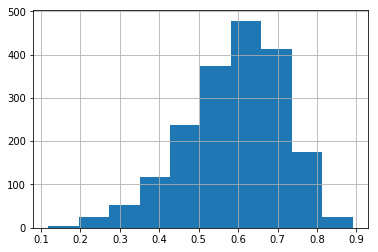

In [28]:
reddit_pred_df['max_sim_to_conclusion'].hist()

In [29]:
all_pred_scores = []
for lvl in [[0, 0.6], [0.6, 0.8], [0.8, 1.1], [0, 1.1]]:
    reddit_pred_df_part = reddit_pred_df[(reddit_pred_df['max_sim_to_conclusion'] >= lvl[0]) & (reddit_pred_df['max_sim_to_conclusion'] < lvl[1])].copy()
    pred_df_scores = get_evaluation_results(reddit_pred_df_part, ceph_dir + data_path)
    print_results(pred_df_scores)
    all_pred_scores.append(pred_df_scores)

ProConClient: 100%|██████████| 945/945 [00:15<00:00, 60.82it/s]

ProConClient:   0%|          | 0/945 [00:00<?, ?it/s]

ProConClient: 100%|██████████| 945/945 [00:26<00:00, 60.82it/s]

ProConClient: 100%|██████████| 945/945 [00:17<00:00, 55.39it/s]

                                 bleu    bert-f1score    stance-score (diff)
---------------------------  --------  --------------  ---------------------
Masked Conclusion            0.147855        0.135021                   0.79
BART Conclusion              0.157927        0.174805                   0.72
ArgLexRank Conclusion        0.126133        0.123041                   0.77
Joint Prediction (baseline)  0.152781        0.158605                   0.75
Joint Prediction             0.148699        0.131461                   0.77
Known Conclusion             0.207776        0.185653                   0.64
Distribution is not normal, so using wilcoxon
BART vs baseline (BLEU): False
Distribution is not normal, so using wilcoxon
BART vs baseline (BERT): False
-------
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BLEU): False
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BERT): True
-------
Distribution is


ProConClient: 100%|██████████| 919/919 [00:15<00:00, 58.83it/s]

ProConClient:   0%|          | 0/919 [00:00<?, ?it/s]

ProConClient:  54%|█████▍    | 500/919 [00:07<00:06, 64.13it/s]

ProConClient: 100%|██████████| 919/919 [00:14<00:00, 62.92it/s]


ProConClient: 100%|██████████| 919/919 [00:23<00:00, 39.16it/s]



ProConClient:  54%|█████▍    | 500/919 [00:08<00:07, 56.18it/s]


ProConClient:  54%|█████▍    | 500/919 [00:08<00:07, 58.79it/s]


ProConClient: 100%|██████████| 919/919 [00:16<00:00, 55.75it/s]

                                 bleu    bert-f1score    stance-score (diff)
---------------------------  --------  --------------  ---------------------
Masked Conclusion            0.154162        0.155869                   0.75
BART Conclusion              0.190544        0.191916                   0.68
ArgLexRank Conclusion        0.141532        0.144348                   0.72
Joint Prediction (baseline)  0.161747        0.174215                   0.75
Joint Prediction             0.191842        0.157951                   0.75
Known Conclusion             0.208531        0.194491                   0.59
Distribution is not normal, so using wilcoxon
BART vs baseline (BLEU): True
Distribution is not normal, so using wilcoxon
BART vs baseline (BERT): False
-------
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BLEU): False
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BERT): True
-------
Distribution is 


ProConClient: 100%|██████████| 37/37 [00:05<00:00,  6.21it/s]

ProConClient: 100%|██████████| 37/37 [00:11<00:00, 38.33it/s]

ProConClient: 100%|██████████| 37/37 [00:06<00:00,  6.08it/s]


ProConClient:   0%|          | 0/37 [00:00<?, ?it/s]


ProConClient: 100%|██████████| 37/37 [00:06<00:00,  6.14it/s]



ProConClient:   0%|          | 0/37 [00:00<?, ?it/s]



ProConClient: 100%|██████████| 37/37 [00:05<00:00,  6.23it/s]




ProConClient:   0%|          | 0/37 [00:00<?, ?it/s]




ProConClient: 100%|██████████| 37/37 [00:06<00:00,  5.88it/s]

                                 bleu    bert-f1score    stance-score (diff)
---------------------------  --------  --------------  ---------------------
Masked Conclusion            0.172278        0.153294                   0.54
BART Conclusion              0.172618        0.178094                   0.72
ArgLexRank Conclusion        0.141577        0.13783                    0.53
Joint Prediction (baseline)  0.171952        0.185987                   0.6
Joint Prediction             0.296713        0.223745                   0.76
Known Conclusion             0.192484        0.168208                   0.48
Distribution is not normal, so using wilcoxon
BART vs baseline (BLEU): False
Distribution is not normal, so using wilcoxon
BART vs baseline (BERT): False
-------
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BLEU): False
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BERT): True
-------
Distribution is 


ProConClient: 100%|██████████| 1901/1901 [00:51<00:00, 37.04it/s]

ProConClient: 100%|██████████| 1901/1901 [00:22<00:00, 73.76it/s] 

ProConClient:   0%|          | 0/1901 [00:00<?, ?it/s]

ProConClient: 100%|██████████| 1901/1901 [00:32<00:00, 73.76it/s][A

ProConClient:  53%|█████▎    | 1000/1901 [00:12<00:10, 82.10it/s]

ProConClient: 100%|██████████| 1901/1901 [00:45<00:00, 42.21it/s]


ProConClient:  26%|██▋       | 500/1901 [00:06<00:17, 81.43it/s]]

ProConClient: 100%|██████████| 1901/1901 [00:24<00:00, 77.29it/s]

                                 bleu    bert-f1score    stance-score (diff)
---------------------------  --------  --------------  ---------------------
Masked Conclusion            0.151418        0.145457                   0.77
BART Conclusion              0.174852        0.183144                   0.7
ArgLexRank Conclusion        0.133795        0.133631                   0.74
Joint Prediction (baseline)  0.157331        0.166682                   0.75
Joint Prediction             0.173105        0.146069                   0.76
Known Conclusion             0.207872        0.189583                   0.61
Distribution is not normal, so using wilcoxon
BART vs baseline (BLEU): True
Distribution is not normal, so using wilcoxon
BART vs baseline (BERT): False
-------
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BLEU): False
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BERT): True
-------
Distribution is n

ProConClient: 100%|██████████| 1901/1901 [00:37<00:00, 77.29it/s]

In [32]:
for s in all_pred_scores:
    print_results(s)

                                 bleu    bert-f1score    stance-score (diff)
---------------------------  --------  --------------  ---------------------
Masked Conclusion            0.147855        0.135021                   0.79
BART Conclusion              0.157927        0.174805                   0.72
ArgLexRank Conclusion        0.126133        0.123041                   0.77
Joint Prediction (baseline)  0.152781        0.158605                   0.75
Joint Prediction             0.148699        0.131461                   0.77
Known Conclusion             0.207776        0.185653                   0.64
Distribution is not normal, so using wilcoxon
BART vs baseline (BLEU): False
Distribution is not normal, so using wilcoxon
BART vs baseline (BERT): False
-------
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BLEU): False
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BERT): True
-------
Distribution is

#### Analyze effectiveness for different levels of argument length:

In [30]:
reddit_pred_df['arg_len'] = reddit_pred_df.premises.apply(lambda x: len(nltk.word_tokenize(x)))

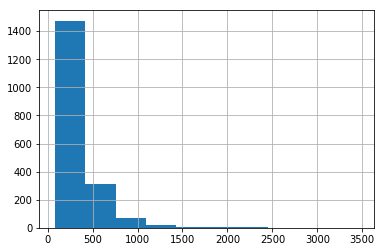

In [33]:
reddit_pred_df['arg_len'].hist()

In [37]:
all_pred_scores_per_len = []
for lvl in [[0, 200], [200, 400], [400, 100000]]:
    reddit_pred_df_part = reddit_pred_df[(reddit_pred_df['arg_len'] >= lvl[0]) & (reddit_pred_df['arg_len'] < lvl[1])]
    print('Number of samples {}'.format(len(reddit_pred_df_part)))
    
    pred_df_scores = get_evaluation_results(reddit_pred_df_part, ceph_dir + data_path)
    print_results(pred_df_scores)
    all_pred_scores_per_len.append(pred_df_scores)

Number of samples 656


ProConClient: 100%|██████████| 1901/1901 [18:35:46<00:00, 35.22s/it]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ProConClient: 100%|██████████| 656/656 [00:12<00:00, 54.61it/s]

ProConClient: 100%|██████████| 656/656 [00:21<00:00, 30.77it/s]


ProConClient:  76%|███████▌  | 500/656 [00:09<00:02, 53.98it/s]

ProConClient:   0%|          

                                 bleu    bert-f1score    stance-score (diff)
---------------------------  --------  --------------  ---------------------
Masked Conclusion            0.151658        0.151095                   0.75
BART Conclusion              0.169289        0.189602                   0.69
ArgLexRank Conclusion        0.136987        0.139877                   0.74
Joint Prediction (baseline)  0.150047        0.173574                   0.75
Joint Prediction             0.170702        0.153879                   0.74
Known Conclusion             0.207252        0.195973                   0.58
Distribution is not normal, so using wilcoxon
BART vs baseline (BLEU): True
Distribution is not normal, so using wilcoxon
BART vs baseline (BERT): False
-------
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BLEU): False
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BERT): True
-------
Distribution is 


ProConClient: 100%|██████████| 656/656 [00:52<00:00, 12.51it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ProConClient: 100%|██████████| 771/771 [00:12<00:00, 60.98it/s]

ProConClient: 100%|██████████| 771/771 [00:18<00:00, 103.56it/s]

ProConClient: 100%|██████████| 771/771 [00:22<00:00, 34.66it/s]


ProConClient:   0%|          | 0

                                 bleu    bert-f1score    stance-score (diff)
---------------------------  --------  --------------  ---------------------
Masked Conclusion            0.14884         0.147862                   0.77
BART Conclusion              0.175515        0.188097                   0.69
ArgLexRank Conclusion        0.131798        0.138812                   0.76
Joint Prediction (baseline)  0.165626        0.172195                   0.76
Joint Prediction             0.173109        0.149326                   0.79
Known Conclusion             0.20674         0.192137                   0.62
Distribution is not normal, so using wilcoxon
BART vs baseline (BLEU): True
Distribution is not normal, so using wilcoxon
BART vs baseline (BERT): False
-------
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BLEU): False
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BERT): True
-------
Distribution is 


ProConClient: 100%|██████████| 771/771 [00:50<00:00, 15.15it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ProConClient: 100%|██████████| 474/474 [00:03<00:00, 148.32it/s]

ProConClient: 100%|██████████| 474/474 [00:06<00:00, 69.07it/s]

ProConClient: 100%|██████████| 474/474 [00:04<00:00, 117.94it/s]

ProConClient: 100%|██████████| 4

                                 bleu    bert-f1score    stance-score (diff)
---------------------------  --------  --------------  ---------------------
Masked Conclusion            0.154739        0.133753                   0.8
BART Conclusion              0.180904        0.166134                   0.73
ArgLexRank Conclusion        0.132421        0.116553                   0.72
Joint Prediction (baseline)  0.153303        0.14819                    0.73
Joint Prediction             0.17614         0.129934                   0.76
Known Conclusion             0.210407        0.176572                   0.66
Distribution is not normal, so using wilcoxon
BART vs baseline (BLEU): False
Distribution is not normal, so using wilcoxon
BART vs baseline (BERT): False
-------
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BLEU): False
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BERT): True
-------
Distribution is 

In [38]:
for s in all_pred_scores:
    all_pred_scores_per_len(s)

ProConClient: 100%|██████████| 474/474 [00:34<00:00, 13.67it/s]


TypeError: 'list' object is not callable

### Run experiments by removing premises that are similar to the conclusion:

In [17]:
levels_of_masking = [1.0, 0.75, 0.6, 0.5]

gen_kwargs = {
    "do_sample": False, 
    "max_length":100,
    "num_beams":10
}

all_pred_scores = []
for lvl in levels_of_masking:
    masked_clm = '{}_perc_masked_premises'.format(lvl*10)
    valid_df = remove_similar_sents(valid_df, threshold=lvl, masked_clm = masked_clm)

    #Create a dataset
    unique_valid_posts = valid_df.drop_duplicates('post_id')
    valid_ds = Dataset.from_pandas(unique_valid_posts)
    #If we want to take a small sample..
    #valid_ds = valid_ds.train_test_split(0.5)
    #valid_ds = valid_ds['test']
    valid_ds = valid_ds.flatten_indices()

    #generate predictions
    reddit_pred_df = create_predictions_df(valid_ds, gen_kwargs, premises_clm=masked_clm)
    reddit_pred_df.to_pickle('../data/output/reddit_pred_df_{}.pkl'.format(masked_clm))
    
    pred_df_scores = get_evaluation_results(reddit_pred_df, ceph_dir + data_path)
    print_results(pred_df_scores)
    all_pred_scores.append(pred_df_scores)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

ProConClient: 100%|██████████| 1499/1499 [00:26<00:00, 56.92it/s]

                                 bleu    bert-f1score    stance-score (diff)
---------------------------  --------  --------------  ---------------------
Masked Conclusion            0.133543        0.117534                   0.74
BART Conclusion              0.136626        0.166914                   0.89
ArgLexRank Conclusion        0.127403        0.120435                   0.77
Joint Prediction (baseline)  0.143528        0.140205                   0.81
Joint Prediction             0.152893        0.119865                   0.73
Known Conclusion             0.196081        0.167839                   0.87
Distribution is not normal, so using wilcoxon
BART vs baseline (BLEU): True
Distribution is not normal, so using wilcoxon
BART vs baseline (BERT): False
-------
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BLEU): False
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BERT): True
-------
Distribution is 

ProConClient: 100%|██████████| 1499/1499 [00:34<00:00, 43.94it/s]


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

ProConClient: 100%|██████████| 1499/1499 [00:22<00:00, 69.14it/s]

                                 bleu    bert-f1score    stance-score (diff)
---------------------------  --------  --------------  ---------------------
Masked Conclusion            0.126556        0.109075                   0.76
BART Conclusion              0.134031        0.167167                   0.89
ArgLexRank Conclusion        0.127082        0.11991                    0.78
Joint Prediction (baseline)  0.139894        0.129912                   0.82
Joint Prediction             0.139065        0.109321                   0.72
Known Conclusion             0.19497         0.167571                   0.88
Distribution is not normal, so using wilcoxon
BART vs baseline (BLEU): True
Distribution is not normal, so using wilcoxon
BART vs baseline (BERT): False
-------
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BLEU): False
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BERT): True
-------
Distribution is 


ProConClient: 100%|██████████| 1499/1499 [00:40<00:00, 69.14it/s]